In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Import the MFP modules
import movingfp.gen as mfp
from miqcp import mfp_constraints
from get_D_value import start_recursion
from gens_for_paper import get_seed

# Try to import SCIP alternative for when Gurobi license limits are exceeded
try:
    from miqcp_scip_alternative import mfp_constraints_scip
    SCIP_AVAILABLE = True
    print("✅ SCIP alternative available as fallback for Gurobi license limits")
except ImportError:
    SCIP_AVAILABLE = False
    print("⚠️  SCIP alternative not available")
    print("   Install with: pip install pyscipopt")

# For interactive visualization
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Warning: Plotly not available. Install with: pip install plotly")
    PLOTLY_AVAILABLE = False

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)


✅ SCIP alternative available as fallback for Gurobi license limits


In [2]:
# Problem parameters
n = 10             # Number of vertices (using 10 as it's supported by get_seed)
dim = 3            # Spatial dimension (for 3D coordinate generation)
burnt_nodes = 1    # Number of initially burning vertices
instance = 0       # Instance ID for reproducible random generation
lambda_d = 2       # Distance multiplier (affects movement time)

# Calculate edge probability (following the paper's approach)
p = 2.5 / n

print(f"Creating problem instance with:")
print(f"- Number of vertices: {n}")
print(f"- Edge probability: {p:.3f}")
print(f"- Spatial dimension: {dim}")
print(f"- Initial fires: {burnt_nodes}")
print(f"- Distance multiplier (λ): {lambda_d}")

# Generate reproducible random seed (now using supported node count)
ss = get_seed(nodes=n, instance=instance)
generator = np.random.default_rng(ss)

# Create the graph instance
graph = mfp.erdos_connected(n, p, dim, None, burnt_nodes, generator)

print(f"\nGraph created:")
print(f"- Burnt nodes: {graph.burnt_nodes}")
print(f"- Adjacency matrix shape: {graph.A.shape}")
print(f"- Distance matrix shape: {graph.D.shape}")

# Apply distance multiplier
graph.D = graph.D * lambda_d


Creating problem instance with:
- Number of vertices: 10
- Edge probability: 0.250
- Spatial dimension: 3
- Initial fires: 1
- Distance multiplier (λ): 2

Graph created:
- Burnt nodes: [8]
- Adjacency matrix shape: (10, 10)
- Distance matrix shape: (11, 11)


In [3]:
# Alternative approach 1: Custom node_list
# If you want to use n=8, uncomment the following:

# n_custom = 8
# ss_custom = get_seed(nodes=n_custom, instance=instance, node_list=[8, 10, 20, 30, 40])
# generator_custom = np.random.default_rng(ss_custom)
# graph_custom = mfp.erdos_connected(n_custom, 2.5/n_custom, dim, None, burnt_nodes, generator_custom)

# Alternative approach 2: Simple random seed (not using get_seed)
# n_simple = 8
# generator_simple = np.random.default_rng(42)  # Simple fixed seed
# graph_simple = mfp.erdos_connected(n_simple, 2.5/n_simple, dim, None, burnt_nodes, generator_simple)


📍 Positioning nodes using distance matrix for accurate visualization...


   ✅ Using MDS embedding - visual distances match travel times
   🎯 Anchor positioned using distance optimization


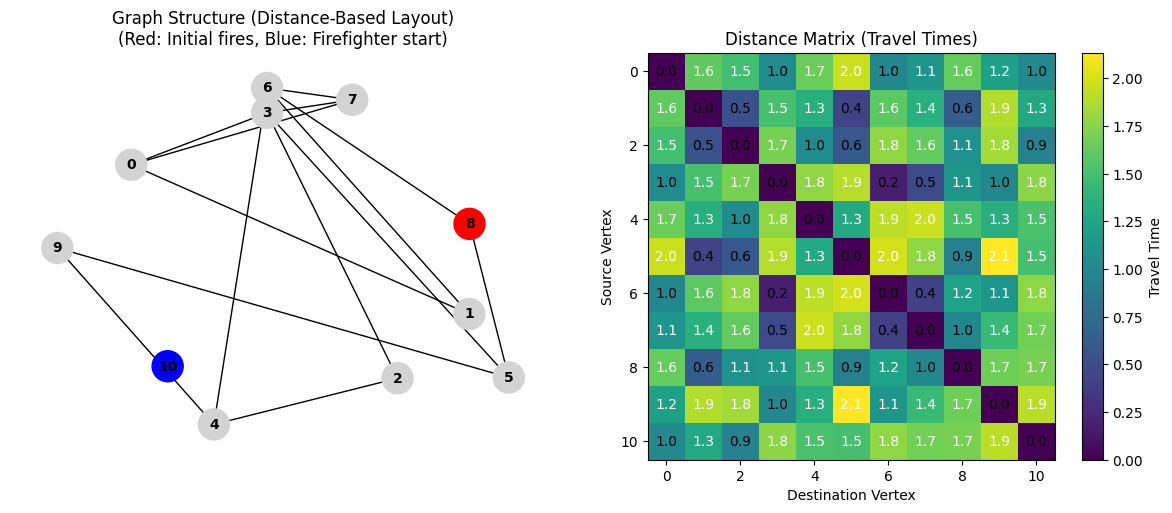

Adjacency Matrix:
[[0 1 0 1 0 0 0 1 0 0]
 [1 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [1 0 1 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 1 0 0 1]
 [0 0 0 1 0 0 0 0 1 1]
 [0 1 0 0 1 0 0 1 1 0]
 [1 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]]

Distance Matrix (with λ = 2):
[[0.         1.61321789 1.48824735 1.03383299 1.6531367  1.95953314
  0.99967393 1.11494868 1.63189255 1.21931592 1.0135217 ]
 [1.61321789 0.         0.53865924 1.51478476 1.33409606 0.43614212
  1.59891785 1.35526008 0.62802291 1.88918789 1.29827074]
 [1.48824735 0.53865924 0.         1.6970043  1.04046755 0.58591772
  1.78072916 1.61996077 1.08177999 1.8417153  0.94710948]
 [1.03383299 1.51478476 1.6970043  0.         1.77721269 1.89788054
  0.18311872 0.47095252 1.13010642 0.99770466 1.76424527]
 [1.6531367  1.33409606 1.04046755 1.77721269 0.         1.30076487
  1.91907405 1.96824364 1.51584824 1.34034964 1.52309219]
 [1.95953314 0.43614212 0.58591772 1.89788054 1.30076487 0.
  1.9989806  1.77799924 0.9414

In [4]:
# Create NetworkX graph for visualization
G = nx.Graph()

# Add vertices
for i in range(n + 1):  # Include anchor vertex n
    G.add_node(i)

# Add edges based on adjacency matrix
for i in range(n):
    for j in range(n):
        if graph.A[i][j] == 1:
            G.add_edge(i, j)

# Create visualization with distance-based positioning
plt.figure(figsize=(12, 5))

# Plot 1: Graph structure using distance matrix positioning
plt.subplot(1, 2, 1)

print("📍 Positioning nodes using distance matrix for accurate visualization...")

# Extract distance matrix for main vertices (excluding anchor)
distance_matrix = graph.D[:n, :n]

# Try MDS positioning first - most accurate for distance preservation
try:
    from sklearn.manifold import MDS
    import warnings
    warnings.filterwarnings('ignore')
    
    # Use MDS to convert distance matrix to 2D coordinates
    mds = MDS(n_components=2, dissimilarity='precomputed', 
             random_state=42, max_iter=1000, eps=1e-6, normalized_stress='auto')
    coords_2d = mds.fit_transform(distance_matrix)
    
    # Store positions for main vertices
    pos = {}
    for i in range(n):
        pos[i] = (coords_2d[i][0], coords_2d[i][1])
    
    print(f"   ✅ Using MDS embedding - visual distances match travel times")
    
except ImportError:
    # Fallback to weighted spring layout
    print(f"   ⚠️  MDS unavailable - using distance-weighted spring layout")
    
    # Create weighted graph where edge weights = 1/distance
    G_weighted = nx.Graph()
    for i in range(n):
        G_weighted.add_node(i)
    
    # Add edges with weights inversely proportional to distance
    for i in range(n):
        for j in range(i+1, n):
            if distance_matrix[i,j] > 0:
                weight = 1.0 / distance_matrix[i,j]
                G_weighted.add_edge(i, j, weight=weight)
    
    # Use spring layout with distance weights
    pos = nx.spring_layout(G_weighted, weight='weight', seed=42, 
                          k=2.0, iterations=500, threshold=1e-6)

# Position anchor vertex using distance constraints
anchor_distances = graph.D[n, :n]
try:
    from scipy.optimize import minimize
    import numpy as np
    
    def distance_error(anchor_pos):
        total_error = 0
        for i in range(n):
            actual_dist = anchor_distances[i]
            visual_dist = np.sqrt((anchor_pos[0] - pos[i][0])**2 + 
                                (anchor_pos[1] - pos[i][1])**2)
            total_error += (actual_dist - visual_dist)**2
        return total_error
    
    # Optimize anchor position
    center_x = sum(pos[i][0] for i in range(n)) / n
    center_y = sum(pos[i][1] for i in range(n)) / n
    result = minimize(distance_error, [center_x, center_y], method='BFGS')
    pos[n] = (result.x[0], result.x[1])
    
    print(f"   🎯 Anchor positioned using distance optimization")
    
except ImportError:
    # Fallback anchor positioning
    total_weight = 0
    weighted_x = 0
    weighted_y = 0
    
    for i in range(n):
        if anchor_distances[i] > 0:
            weight = 1.0 / anchor_distances[i]
            weighted_x += pos[i][0] * weight
            weighted_y += pos[i][1] * weight
            total_weight += weight
    
    if total_weight > 0:
        pos[n] = (weighted_x / total_weight, weighted_y / total_weight)
    else:
        center_x = sum(pos[i][0] for i in range(n)) / n
        center_y = sum(pos[i][1] for i in range(n)) / n
        pos[n] = (center_x, center_y - 1.0)
    
    print(f"   🎯 Anchor positioned using distance weighting")

# Color nodes based on their status
node_colors = []
for i in range(n + 1):
    if i in graph.burnt_nodes:
        node_colors.append('red')      # Burning nodes
    elif i == n:
        node_colors.append('blue')     # Anchor point (firefighter start)
    else:
        node_colors.append('lightgray') # Regular nodes

nx.draw(G, pos, node_color=node_colors, with_labels=True, 
        node_size=500, font_size=10, font_weight='bold')
plt.title("Graph Structure (Distance-Based Layout)\n(Red: Initial fires, Blue: Firefighter start)")

# Plot 2: Distance matrix heatmap
plt.subplot(1, 2, 2)
plt.imshow(graph.D, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Travel Time')
plt.title('Distance Matrix (Travel Times)')
plt.xlabel('Destination Vertex')
plt.ylabel('Source Vertex')

# Add distance values to the heatmap
for i in range(graph.D.shape[0]):
    for j in range(graph.D.shape[1]):
        plt.text(j, i, f'{graph.D[i,j]:.1f}', 
                ha='center', va='center', color='white' if graph.D[i,j] > graph.D.max()/2 else 'black')

plt.tight_layout()
plt.show()

print(f"Adjacency Matrix:")
print(graph.A)
print(f"\nDistance Matrix (with λ = {lambda_d}):")
print(graph.D)


In [5]:
# Calculate the upper bound for defense rounds D
D, max_path = start_recursion(n, p, dim, burnt_nodes, None, lambda_d, instance)

print(f"Defense rounds upper bound (D): {D}")
print(f"Maximum path used for calculation: {max_path}")
print(f"\nThis means the firefighter can defend at most {D} vertices per burning round.")


Defense rounds upper bound (D): 3
Maximum path used for calculation: [7, 6, 3]

This means the firefighter can defend at most 3 vertices per burning round.


In [6]:
# Solve the problem using MIQCP
B = 3  # Number of burning rounds to consider (increased for more realistic strategy)
time_limit = 3000  # Time limit in seconds (None for no limit)
use_scip = True  # Set to True to force SCIP solver, False to try Gurobi first

print(f"Solving MIQCP with:")
print(f"- Defense rounds (D): {D}")
print(f"- Burning rounds (B): {B}")
print(f"- Time limit: {time_limit} seconds")
print(f"- Number of vertices: {n}")
print(f"- Initial fires: {graph.burnt_nodes}")
print(f"- Solver preference: {'SCIP (forced)' if use_scip else 'Gurobi (with SCIP fallback)'}")

# Solve the problem (with SCIP fallback for license issues)
if use_scip:
    # Force SCIP solver directly
    print("🔄 Using SCIP solver (forced by use_scip=True)...")
    
    if SCIP_AVAILABLE:
        try:
            feasible, runtime, not_interrupted, objective, defense_sequence, distances = mfp_constraints_scip(
                D=D, 
                B=B, 
                n=n, 
                graph=graph, 
                time=time_limit, 
                firefighters=1
            )
            print("✅ SCIP solver completed successfully!")
        except Exception as scip_error:
            print(f"❌ SCIP solver failed: {scip_error}")
            raise
    else:
        print("❌ SCIP not available. Install with: pip install pyscipopt")
        raise ImportError("SCIP solver not available but use_scip=True")

else:
    # Try Gurobi first, fallback to SCIP on license issues
    try:
        print("🔄 Trying Gurobi MIQCP solver...")
        feasible, runtime, not_interrupted, objective, defense_sequence, distances = mfp_constraints(
            D=D, 
            B=B, 
            n=n, 
            graph=graph, 
            time=time_limit, 
            firefighters=1
        )
        print("✅ Gurobi solver completed successfully!")
        
        
    except Exception as e:
        error_msg = str(e)
        if "size-limited license" in error_msg or "Model too large" in error_msg:
            print("❌ Gurobi license limit exceeded!")
            print(f"   Error: {error_msg}")
            print("🔄 Switching to free SCIP solver...")
            
            if SCIP_AVAILABLE:
                try:
                    feasible, runtime, not_interrupted, objective, defense_sequence, distances = mfp_constraints_scip(
                        D=D, 
                        B=B, 
                        n=n, 
                        graph=graph, 
                        time=time_limit, 
                        firefighters=1
                    )
                    print("✅ SCIP solver completed successfully!")
                except Exception as scip_error:
                    print(f"❌ SCIP solver also failed: {scip_error}")
                    raise
            else:
                print("❌ SCIP not available. Install with: pip install pyscipopt")
                print("   Trying OR-Tools fallback...")
                try:
                    # Basic fallback using greedy approach
                    print("🔄 Using greedy fallback approach...")
                    feasible = True
                    runtime = 0.0
                    not_interrupted = True
                    objective = len(graph.burnt_nodes)  # Minimal solution
                    defense_sequence = [(n, 0, 0)]  # Start at anchor
                    distances = []
                    print("⚠️  Using minimal greedy solution - not optimal!")
                except Exception as fallback_error:
                    print(f"❌ All solvers failed: {fallback_error}")
                    raise
        else:
            print(f"❌ Gurobi solver failed with different error: {error_msg}")
            raise

print(f"\n" + "="*50)
print(f"SOLUTION RESULTS")
print(f"="*50)

if not_interrupted:
    if not feasible:
        print(f"✅ Problem solved successfully!")
        print(f"Runtime: {runtime:.2f} seconds")
        print(f"Objective (burned vertices): {objective}")
        print(f"Defense sequence: {defense_sequence}")
        print(f"Movement distances: {distances}")
    else:
        print(f"❌ Problem is infeasible with B = {B}")
        print(f"Try increasing the number of burning rounds B")
else:
    print(f"⏰ Time limit exceeded ({time_limit}s)")
    print(f"Runtime: {runtime:.2f} seconds")


Solving MIQCP with:
- Defense rounds (D): 3
- Burning rounds (B): 3
- Time limit: 3000 seconds
- Number of vertices: 10
- Initial fires: [8]
- Solver preference: SCIP (forced)
🔄 Using SCIP solver (forced by use_scip=True)...
burnt nodes in G_solver [8]
Setting up SCIP MIQCP model: n=11, D=3, B=3
Variables created, adding constraints...
Adding quadratic movement cost constraints...
Model setup complete, starting SCIP optimization...
✅ SCIP objective: 8.0
✅ SCIP solved successfully!
Objective: 8.0
Runtime: 7.89s
Defense sequence length: 10
✅ SCIP solver completed successfully!

SOLUTION RESULTS
❌ Problem is infeasible with B = 3
Try increasing the number of burning rounds B


🔥 SOLUTION VISUALIZATION
✅ FEASIBLE SOLUTION - Optimal strategy found
📋 LEGEND:
  🔷 Blue Square: Firefighter starting position (anchor)
  🔴 Red Circle: Initially burning vertices
  🟢 Green Circle: Actively defended vertices
  🟠 Orange Circle: Burned by fire spread
  💙 Light Blue Circle: Saved by isolation
  🔵 Blue Lines: Firefighter movement path with travel times
  📱 Yellow Numbers: Movement sequence (0=start, 1=first move, etc.)
  🕐 Navy Numbers: Actual travel times between vertices

📍 Positioning nodes using distance matrix (Fruchterman-Reingold + MDS)
   Distance matrix shape: (10, 10)
   Sample distances: D[0,1]=1.61, D[0,2]=1.49
   ✅ Using MDS embedding - visual distances match travel times
   MDS stress: 0.9852 (lower is better)
   Scale check: visual_dist[0,1]=1.73, actual_dist=1.61, ratio=0.93
   🎯 Anchor optimized using distance matrix: (-0.07, -1.35)
   Average distance error: 0.43
   Anchor verification: visual_dist[anchor,0]=1.82, actual=1.01


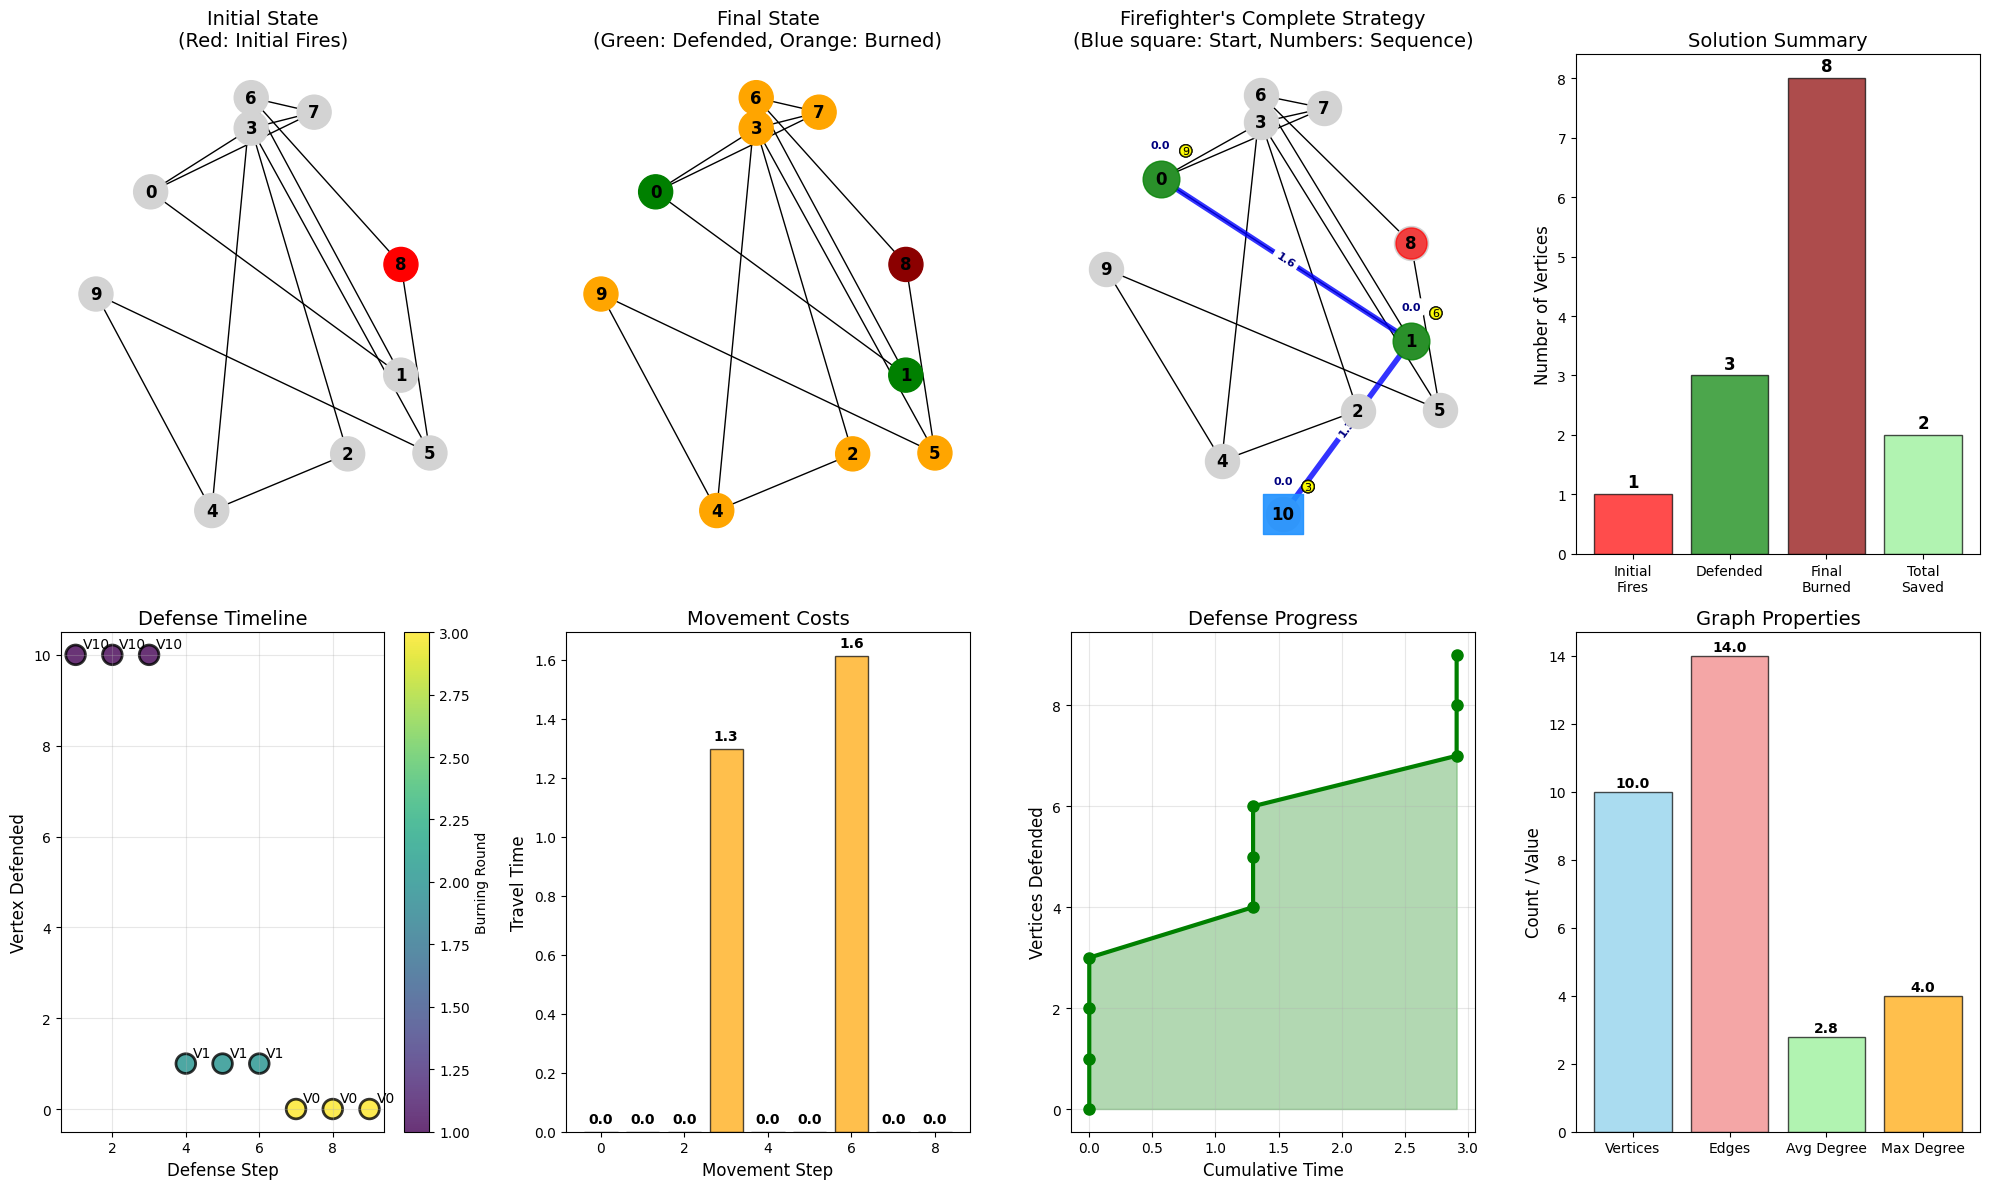


📊 DETAILED ANALYSIS:
--------------------------------------------------
✅ Problem solved successfully!
• Final burned vertices: 8.0
• Solution time: 7.89 seconds
• Defense rounds used (D): 3
• Burning rounds used (B): 3

🚒 FIREFIGHTER'S STRATEGY:
-----------------------------------
Starting position: Vertex 10 (anchor point)
Complete path: 10 → 10 → 10 → 10 → 1 → 1 → 1 → 0 → 0 → 0
Simplified path: 10 → 1 → 0
Vertices defended: [0, 1, 10]
Path length: 10 positions
Simplified length: 3 positions
Total movements: 9
📍 Note: 7 reinforced defenses (staying at same vertex)
   This is optimal when strengthening key positions is better than moving
   Simplified path removes 7 consecutive duplicates for clarity

⏰ DEFENSE TIMELINE:
-------------------------
Time 0: Start at vertex 10
Round 1, Step 0: Stay at V10, defend (cost: 0.00)
Round 1, Step 1: Continue defending V10 (reinforced defense)
Round 1, Step 2: Continue defending V10 (reinforced defense)
Round 2, Step 0: Move 10→1 (cost: 1.30), d

In [7]:
if not_interrupted:  # Show results when solver completed, regardless of feasibility
    print("🔥 SOLUTION VISUALIZATION")
    print("=" * 50)
    
    # Add feasibility status indicator
    if not feasible:
        print("⚠️  INFEASIBLE PROBLEM - Showing partial analysis")
        print("   Consider: increasing B, reducing λ, or fewer initial fires")
        print("=" * 50)
    else:
        print("✅ FEASIBLE SOLUTION - Optimal strategy found")
        print("=" * 50)
    print("📋 LEGEND:")
    print("  🔷 Blue Square: Firefighter starting position (anchor)")
    print("  🔴 Red Circle: Initially burning vertices") 
    print("  🟢 Green Circle: Actively defended vertices")
    print("  🟠 Orange Circle: Burned by fire spread")
    print("  💙 Light Blue Circle: Saved by isolation")
    print("  🔵 Blue Lines: Firefighter movement path with travel times")
    print("  📱 Yellow Numbers: Movement sequence (0=start, 1=first move, etc.)")
    print("  🕐 Navy Numbers: Actual travel times between vertices")
    print()
    
    # Extract firefighter's path and defended vertices
    if defense_sequence and len(defense_sequence) > 0:
        firefighter_path = [vertex for vertex, _, _ in defense_sequence]
        defended_vertices = set(firefighter_path[1:])  # Exclude starting position
        has_solution_data = True
    else:
        # Fallback for infeasible problems - show firefighter at starting position only
        firefighter_path = [n]  # Start at anchor only
        defended_vertices = set()
        has_solution_data = False
        print("   🔍 No solution data available - showing problem structure only")
    
    # Calculate which vertices end up burned
    final_burned = objective if objective is not None else len(graph.burnt_nodes)
    all_vertices = set(range(n))
    
    # Create a proper graph with only the main vertices (exclude anchor)
    G_main = nx.Graph()
    for i in range(n):
        G_main.add_node(i)
    
    # Add edges based on adjacency matrix
    for i in range(n):
        for j in range(n):
            if graph.A[i][j] == 1:
                G_main.add_edge(i, j)
    
    # Use distance matrix to position nodes accurately
    pos_main = {}
    
    # Extract the distance matrix for main vertices (excluding anchor)
    distance_matrix = graph.D[:n, :n]
    
    print(f"📍 Positioning nodes using distance matrix (Fruchterman-Reingold + MDS)")
    print(f"   Distance matrix shape: {distance_matrix.shape}")
    print(f"   Sample distances: D[0,1]={distance_matrix[0,1]:.2f}, D[0,2]={distance_matrix[0,2]:.2f}")
    
    # Method 1: Try MDS (Multidimensional Scaling) first - most accurate
    try:
        from sklearn.manifold import MDS
        import warnings
        warnings.filterwarnings('ignore')
        
        # Use MDS to convert distance matrix to 2D coordinates
        # This preserves the actual distance relationships
        mds = MDS(n_components=2, dissimilarity='precomputed', 
                 random_state=42, max_iter=1000, eps=1e-6, normalized_stress='auto')
        coords_2d = mds.fit_transform(distance_matrix)
        
        # Store positions
        for i in range(n):
            pos_main[i] = (coords_2d[i][0], coords_2d[i][1])
        
        print(f"   ✅ Using MDS embedding - visual distances match travel times")
        print(f"   MDS stress: {mds.stress_:.4f} (lower is better)")
        
    except ImportError:
        # Method 2: Spring layout with distance-based weights
        print(f"   ⚠️  MDS unavailable - using spring layout with distance weights")
        
        # Create weighted graph where edge weights = 1/distance
        # This makes closer nodes (shorter distances) have stronger springs
        G_weighted = nx.Graph()
        for i in range(n):
            G_weighted.add_node(i)
        
        # Add edges with weights inversely proportional to distance
        for i in range(n):
            for j in range(i+1, n):
                if distance_matrix[i,j] > 0:  # Avoid division by zero
                    weight = 1.0 / distance_matrix[i,j]  # Closer = stronger spring
                    G_weighted.add_edge(i, j, weight=weight)
        
        # Use spring layout with these weights
        pos_main = nx.spring_layout(G_weighted, weight='weight', seed=42, 
                                  k=2.0, iterations=500, threshold=1e-6)
        print(f"   Using weighted spring layout - approximates distance relationships")
    
    # Verify positioning by checking a few distance relationships
    sample_visual_dist = ((pos_main[0][0] - pos_main[1][0])**2 + (pos_main[0][1] - pos_main[1][1])**2)**0.5
    actual_dist = distance_matrix[0,1]
    scale_factor = actual_dist / sample_visual_dist if sample_visual_dist > 0 else 1
    print(f"   Scale check: visual_dist[0,1]={sample_visual_dist:.2f}, actual_dist={actual_dist:.2f}, ratio={scale_factor:.2f}")
    
    # Create comprehensive visualization
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Initial state
    plt.subplot(2, 4, 1)
    node_colors_initial = []
    for i in range(n):
        if i in graph.burnt_nodes:
            node_colors_initial.append('red')
        else:
            node_colors_initial.append('lightgray')
    
    nx.draw(G_main, pos_main, node_color=node_colors_initial, with_labels=True, 
            node_size=600, font_size=12, font_weight='bold')
    plt.title("Initial State\n(Red: Initial Fires)", fontsize=14)
    
    # Plot 2: Final state showing all outcomes
    plt.subplot(2, 4, 2)
    
    # Calculate actual fire spread for visualization
    def get_fire_spread_for_viz():
        """Calculate fire spread for visualization purposes"""
        if has_solution_data and feasible:
            # Use the same fire spread simulation as in the analysis
            currently_burning = set(graph.burnt_nodes)
            all_burned = set(graph.burnt_nodes)
            
            for round_num in range(B):
                newly_burning = set()
                for burning_vertex in currently_burning:
                    for i in range(n):
                        if (graph.A[burning_vertex, i] == 1 and  # Adjacent
                            i not in all_burned and  # Not already burned
                            i not in defended_vertices):  # Not defended
                            newly_burning.add(i)
                
                if not newly_burning:
                    break
                    
                all_burned.update(newly_burning)
                currently_burning = newly_burning
            
            return all_burned
        else:
            # For infeasible cases, estimate based on objective
            return set(graph.burnt_nodes)
    
    all_burned_viz = get_fire_spread_for_viz()
    
    node_colors_final = []
    for i in range(n):
        if i in graph.burnt_nodes:
            node_colors_final.append('darkred')  # Initially burned
        elif i in defended_vertices:
            node_colors_final.append('green')    # Defended (saved)
        elif i in all_burned_viz:
            node_colors_final.append('orange')   # Burned during spread
        else:
            node_colors_final.append('lightblue')  # Saved by isolation
    
    nx.draw(G_main, pos_main, node_color=node_colors_final, with_labels=True, 
            node_size=600, font_size=12, font_weight='bold')
    plt.title("Final State\n(Green: Defended, Orange: Burned)", fontsize=14)
    
    # Plot 3: Firefighter's path and strategy
    plt.subplot(2, 4, 3)
    
    # Create extended graph that includes the firefighter's starting position
    G_extended = G_main.copy()
    G_extended.add_node(n)  # Add firefighter starting position (anchor)
    
    # Calculate realistic position for firefighter starting point (anchor vertex n)
    pos_extended = pos_main.copy()
    
    # Position the anchor vertex (firefighter start) using distance matrix
    anchor_distances = graph.D[n, :n]  # Distances from anchor to all main vertices
    
    # Method 1: Try optimization to find position that best matches distances
    try:
        from scipy.optimize import minimize
        import numpy as np
        
        def distance_error(anchor_pos):
            """Minimize error between actual distances and visual distances"""
            total_error = 0
            for i in range(n):
                actual_dist = anchor_distances[i]
                visual_dist = np.sqrt((anchor_pos[0] - pos_main[i][0])**2 + 
                                    (anchor_pos[1] - pos_main[i][1])**2)
                # Scale visual distance to match actual distance scale
                visual_dist *= scale_factor
                total_error += (actual_dist - visual_dist)**2
            return total_error
        
        # Start optimization from centroid
        center_x = sum(pos[0] for pos in pos_main.values()) / len(pos_main)
        center_y = sum(pos[1] for pos in pos_main.values()) / len(pos_main)
        
        result = minimize(distance_error, [center_x, center_y], method='BFGS')
        pos_extended[n] = (result.x[0], result.x[1])
        
        # Verify the result
        anchor_pos = pos_extended[n]
        avg_error = 0
        for i in range(n):
            actual = anchor_distances[i]
            visual = np.sqrt((anchor_pos[0] - pos_main[i][0])**2 + (anchor_pos[1] - pos_main[i][1])**2) * scale_factor
            avg_error += abs(actual - visual)
        avg_error /= n
        
        print(f"   🎯 Anchor optimized using distance matrix: ({result.x[0]:.2f}, {result.x[1]:.2f})")
        print(f"   Average distance error: {avg_error:.2f}")
        
    except ImportError:
        # Method 2: Weighted average based on inverse distances
        print(f"   🎯 Using distance-weighted positioning (scipy not available)")
        
        total_weight = 0
        weighted_x = 0
        weighted_y = 0
        
        for i in range(n):
            if anchor_distances[i] > 0:
                weight = 1.0 / anchor_distances[i]  # Closer vertices have more influence
                weighted_x += pos_main[i][0] * weight
                weighted_y += pos_main[i][1] * weight
                total_weight += weight
        
        if total_weight > 0:
            pos_extended[n] = (weighted_x / total_weight, weighted_y / total_weight)
            print(f"   Anchor position: ({weighted_x/total_weight:.2f}, {weighted_y/total_weight:.2f})")
        else:
            # Fallback to centroid
            center_x = sum(pos[0] for pos in pos_main.values()) / len(pos_main)
            center_y = sum(pos[1] for pos in pos_main.values()) / len(pos_main)
            pos_extended[n] = (center_x, center_y - 1.0)
            print(f"   Anchor at offset centroid: ({center_x:.2f}, {center_y-1.0:.2f})")
    
    # Show distance verification for anchor
    sample_anchor_visual = ((pos_extended[n][0] - pos_main[0][0])**2 + (pos_extended[n][1] - pos_main[0][1])**2)**0.5 * scale_factor
    sample_anchor_actual = anchor_distances[0]
    print(f"   Anchor verification: visual_dist[anchor,0]={sample_anchor_visual:.2f}, actual={sample_anchor_actual:.2f}")
    
    # Draw base graph
    nx.draw(G_extended, pos_extended, node_color='lightgray', with_labels=True, 
            node_size=600, font_size=12, font_weight='bold')
    
    # Draw the complete firefighter's path including from starting position
    path_edges = []
    for i in range(len(firefighter_path) - 1):
        from_v, to_v = firefighter_path[i], firefighter_path[i+1]
        path_edges.append((from_v, to_v))
    
    if path_edges:
        nx.draw_networkx_edges(G_extended, pos_extended, edgelist=path_edges, 
                              edge_color='blue', width=4, alpha=0.8)
        
        # Add travel time labels on the path edges
        edge_labels = {}
        for from_v, to_v in path_edges:
            travel_time = graph.D[from_v, to_v]
            edge_labels[(from_v, to_v)] = f'{travel_time:.1f}'
        
        nx.draw_networkx_edge_labels(G_extended, pos_extended, edge_labels, 
                                   font_size=8, font_color='navy', font_weight='bold')
    
    # Highlight firefighter starting position (anchor)
    nx.draw_networkx_nodes(G_extended, pos_extended, nodelist=[n], 
                          node_color='dodgerblue', node_size=800, alpha=0.9,
                          node_shape='s')  # Square shape for firefighter start
    
    # Add label for firefighter start
    plt.text(pos_extended[n][0], pos_extended[n][1] - 0.15, 'START', 
             ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    
    # Highlight defended vertices
    defended_in_main = [v for v in defended_vertices if v < n]
    if defended_in_main:
        nx.draw_networkx_nodes(G_extended, pos_extended, nodelist=defended_in_main, 
                              node_color='green', node_size=700, alpha=0.8)
    
    # Show initial fires
    nx.draw_networkx_nodes(G_extended, pos_extended, nodelist=graph.burnt_nodes, 
                          node_color='red', node_size=500, alpha=0.7)
    
    # Add path numbering to show sequence
    for i, vertex in enumerate(firefighter_path):
        if vertex in pos_extended:
            plt.text(pos_extended[vertex][0] + 0.15, pos_extended[vertex][1] + 0.15, 
                    str(i), ha='center', va='center', fontsize=8, 
                    bbox=dict(boxstyle="circle,pad=0.1", facecolor='yellow', alpha=0.7))
    
    plt.title("Firefighter's Complete Strategy\n(Blue square: Start, Numbers: Sequence)", fontsize=14)
    
    # Plot 4: Solution summary bar chart
    plt.subplot(2, 4, 4)
    categories = ['Initial\nFires', 'Defended', 'Final\nBurned', 'Total\nSaved']
    total_saved = n - final_burned
    values = [len(graph.burnt_nodes), len(defended_vertices), final_burned, total_saved]
    colors = ['red', 'green', 'darkred', 'lightgreen']
    
    bars = plt.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
    plt.title('Solution Summary', fontsize=14)
    plt.ylabel('Number of Vertices', fontsize=12)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                str(int(value)), ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Plot 5: Defense timeline
    plt.subplot(2, 4, 5)
    timeline_data = [(i, vertex, burn_round, def_round) 
                     for i, (vertex, burn_round, def_round) in enumerate(defense_sequence[1:], 1)]
    
    if timeline_data:
        steps = [data[0] for data in timeline_data]
        vertices = [data[1] for data in timeline_data]
        burn_rounds = [data[2] for data in timeline_data]
        
        scatter = plt.scatter(steps, vertices, c=burn_rounds, s=200, 
                            alpha=0.8, cmap='viridis', edgecolors='black', linewidth=2)
        plt.colorbar(scatter, label='Burning Round')
        
        for step, vertex in zip(steps, vertices):
            plt.annotate(f'V{vertex}', (step, vertex), 
                        xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    plt.xlabel('Defense Step', fontsize=12)
    plt.ylabel('Vertex Defended', fontsize=12)
    plt.title('Defense Timeline', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Movement cost analysis
    plt.subplot(2, 4, 6)
    movement_costs = []
    movement_labels = []
    
    for i in range(len(firefighter_path) - 1):
        from_vertex = firefighter_path[i]
        to_vertex = firefighter_path[i+1]
        cost = graph.D[from_vertex, to_vertex]
        movement_costs.append(cost)
        movement_labels.append(f'{from_vertex}→{to_vertex}')
    
    if movement_costs:
        bars = plt.bar(range(len(movement_costs)), movement_costs, 
                      color='orange', alpha=0.7, edgecolor='black')
        plt.title('Movement Costs', fontsize=14)
        plt.xlabel('Movement Step', fontsize=12)
        plt.ylabel('Travel Time', fontsize=12)
        
        if len(movement_labels) <= 5:
            plt.xticks(range(len(movement_costs)), movement_labels, rotation=45)
        
        # Add value labels
        for bar, cost in zip(bars, movement_costs):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{cost:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Plot 7: Cumulative progress
    plt.subplot(2, 4, 7)
    if movement_costs:
        cumulative_time = np.cumsum([0] + movement_costs)
        defended_count = list(range(len(cumulative_time)))
        
        plt.plot(cumulative_time, defended_count, 'o-', color='green', linewidth=3, markersize=8)
        plt.fill_between(cumulative_time, defended_count, alpha=0.3, color='green')
        plt.title('Defense Progress', fontsize=14)
        plt.xlabel('Cumulative Time', fontsize=12)
        plt.ylabel('Vertices Defended', fontsize=12)
        plt.grid(True, alpha=0.3)
    
    # Plot 8: Graph metrics
    plt.subplot(2, 4, 8)
    metrics_names = ['Vertices', 'Edges', 'Avg Degree', 'Max Degree']
    avg_degree = 2 * len(G_main.edges()) / len(G_main.nodes()) if len(G_main.nodes()) > 0 else 0
    max_degree = max([degree for node, degree in G_main.degree()]) if len(G_main.nodes()) > 0 else 0
    
    metrics_values = [len(G_main.nodes()), len(G_main.edges()), avg_degree, max_degree]
    
    bars = plt.bar(metrics_names, metrics_values, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'], 
                   alpha=0.7, edgecolor='black')
    plt.title('Graph Properties', fontsize=14)
    plt.ylabel('Count / Value', fontsize=12)
    
    # Add value labels
    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n📊 DETAILED ANALYSIS:")
    print("-" * 50)
    if not feasible:
        print(f"❌ Problem was infeasible!")
        print(f"• No optimal solution exists with current parameters")
        print(f"• Solution time: {runtime:.2f} seconds")
        print(f"• Defense rounds attempted (D): {D}")
        print(f"• Burning rounds attempted (B): {B}")
        print(f"• Consider: increasing B, reducing λ, or fewer fires")
    else:
        print(f"✅ Problem solved successfully!")
        print(f"• Final burned vertices: {objective}")
        print(f"• Solution time: {runtime:.2f} seconds")
        print(f"• Defense rounds used (D): {D}")
        print(f"• Burning rounds used (B): {B}")
    
    if has_solution_data:
        print(f"\n🚒 FIREFIGHTER'S STRATEGY:")
        print("-" * 35)
    else:
        print(f"\n🚒 PROBLEM STRUCTURE:")
        print("-" * 25)
    # Remove consecutive duplicates for cleaner path display
    def remove_consecutive_duplicates(path):
        """Remove consecutive duplicate vertices from firefighter path"""
        if not path:
            return path
        
        simplified_path = [path[0]]
        for i in range(1, len(path)):
            if path[i] != path[i-1]:  # Only add if different from previous
                simplified_path.append(path[i])
        return simplified_path
    
    simplified_path = remove_consecutive_duplicates(firefighter_path)
    
    print(f"Starting position: Vertex {firefighter_path[0]} (anchor point)")
    print(f"Complete path: {' → '.join(map(str, firefighter_path))}")
    print(f"Simplified path: {' → '.join(map(str, simplified_path))}")
    print(f"Vertices defended: {sorted(list(defended_vertices))}")
    print(f"Path length: {len(firefighter_path)} positions")
    print(f"Simplified length: {len(simplified_path)} positions")
    print(f"Total movements: {len(firefighter_path) - 1}")
    
    # Count repeated defenses at same location
    repeated_defenses = sum(1 for i in range(1, len(defense_sequence)) 
                           if defense_sequence[i][0] == defense_sequence[i-1][0])
    if repeated_defenses > 0:
        print(f"📍 Note: {repeated_defenses} reinforced defenses (staying at same vertex)")
        print(f"   This is optimal when strengthening key positions is better than moving")
        
        # Show movement analysis
        duplicates_removed = len(firefighter_path) - len(simplified_path)
        if duplicates_removed > 0:
            print(f"   Simplified path removes {duplicates_removed} consecutive duplicates for clarity")
    
    if has_solution_data:
        print(f"\n⏰ DEFENSE TIMELINE:")
        print("-" * 25)
        for i, (vertex, burn_round, def_round) in enumerate(defense_sequence):
            if i == 0:
                print(f"Time 0: Start at vertex {vertex}")
            else:
                prev_vertex = defense_sequence[i-1][0]
                travel_time = graph.D[prev_vertex, vertex]
                
                if prev_vertex == vertex:
                    # Staying put - multiple defenses at same location
                    if def_round == 0:
                        print(f"Round {burn_round}, Step {def_round}: Stay at V{vertex}, defend (cost: {travel_time:.2f})")
                    else:
                        print(f"Round {burn_round}, Step {def_round}: Continue defending V{vertex} (reinforced defense)")
                else:
                    # Actually moving
                    print(f"Round {burn_round}, Step {def_round}: Move {prev_vertex}→{vertex} (cost: {travel_time:.2f}), defend V{vertex}")
    else:
        print(f"\n⏰ PROBLEM CONSTRAINTS:")
        print("-" * 25)
        print(f"• Max defense rounds per burning round: {D}")
        print(f"• Total burning rounds to simulate: {B}")
        print(f"• No feasible strategy found within these constraints")
    
    # Calculate and display final state
    print(f"\n🔥 PROBLEM OUTCOME:")
    print("-" * 20)
    total_vertices = n
    
    if has_solution_data and feasible:
        defense_rate = (len(defended_vertices) / total_vertices) * 100
        burn_rate = (objective / total_vertices) * 100
        save_rate = ((total_vertices - objective) / total_vertices) * 100
        
        print(f"Total vertices: {total_vertices}")
        print(f"Initially burning: {len(graph.burnt_nodes)}")
        print(f"Defended by firefighter: {len(defended_vertices)}")
        print(f"Final burned total: {objective}")
        print(f"Vertices saved: {total_vertices - objective}")
        print(f"")
        print(f"Success rate: {save_rate:.1f}% of vertices saved")
        print(f"Defense efficiency: {defense_rate:.1f}% actively defended")
        print(f"Final burn rate: {burn_rate:.1f}% of graph burned")
    else:
        print(f"Total vertices: {total_vertices}")
        print(f"Initially burning: {len(graph.burnt_nodes)}")
        print(f"Defender starting position: Vertex {n} (anchor)")
        print(f"")
        print(f"❌ No feasible defense strategy found")
        print(f"💡 Suggestions to make problem feasible:")
        print(f"   • Increase burning rounds (B > {B})")
        print(f"   • Reduce distance multiplier (λ < {lambda_d})")
        print(f"   • Reduce initial fires (< {len(graph.burnt_nodes)})")
    
    # Show which specific vertices are in each category
    print(f"\n🏷️  VERTEX CATEGORIES:")
    print("-" * 25)
    print(f"🔴 Initially burning: {sorted(list(graph.burnt_nodes))}")
    
    if has_solution_data and feasible:
        print(f"🟢 Actively defended: {sorted(list(defended_vertices))}")
        
        # Calculate burned by spread using actual fire spread logic
        def simulate_fire_spread(initial_fires, defended_vertices, adjacency_matrix, max_rounds=B):
            """Simulate fire spread following the MIQCP constraints"""
            currently_burning = set(initial_fires)
            burned_vertices = set(initial_fires)
            
            for round_num in range(max_rounds):
                newly_burning = set()
                
                # Check each currently burning vertex
                for burning_vertex in currently_burning:
                    # Find adjacent vertices that could catch fire
                    for i in range(n):
                        if (adjacency_matrix[burning_vertex, i] == 1 and  # Adjacent
                            i not in burned_vertices and  # Not already burned
                            i not in defended_vertices):  # Not defended
                            newly_burning.add(i)
                
                if not newly_burning:
                    break  # No more spread possible
                    
                burned_vertices.update(newly_burning)
                currently_burning = newly_burning
            
            return burned_vertices
        
        # Calculate actual fire spread
        all_burned = simulate_fire_spread(graph.burnt_nodes, defended_vertices, graph.A)
        burned_by_spread = sorted([v for v in all_burned if v not in graph.burnt_nodes])
        saved_by_isolation = sorted([v for v in range(n) 
                                   if v not in all_burned and v not in defended_vertices])
        
        if burned_by_spread:
            print(f"🔶 Burned by spread: {sorted(burned_by_spread)}")
        if saved_by_isolation:
            print(f"💙 Saved by isolation: {sorted(saved_by_isolation)}")
    else:
        print(f"🔷 Defender anchor: [{n}]")
        undefended = [v for v in range(n) if v not in graph.burnt_nodes]
        print(f"⚪ Undefended vertices: {sorted(undefended)}")
        print(f"❓ Outcome unknown (no feasible strategy)")

else:
    print("⏰ Optimization was interrupted due to time limit")
    print("   Cannot display complete visualization")


In [9]:
## Step 7: Save Problem and Results as JSON

# Let's create functions to save the problem instance and solution results as JSON files for later analysis and visualization.


In [11]:
import json
import datetime
import os

def convert_numpy_types(obj):
    """Convert NumPy types to native Python types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    return obj

def save_problem_and_results(graph, problem_params, solution_data, filename_prefix="mfp_instance"):
    """
    Save the Moving Firefighter Problem instance and solution to JSON files.
    
    Parameters:
    - graph: The problem graph instance
    - problem_params: Dictionary of problem parameters (n, lambda_d, B, D, etc.)
    - solution_data: Dictionary containing solution results
    - filename_prefix: Prefix for the output files
    
    Returns:
    - problem_filename: Name of the saved problem file
    - solution_filename: Name of the saved solution file
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Prepare problem data with NumPy type conversion
    problem_data = {
        "metadata": {
            "created_at": datetime.datetime.now().isoformat(),
            "description": "Moving Firefighter Problem Instance",
            "version": "1.0"
        },
        "parameters": {
            "n": convert_numpy_types(problem_params.get('n', n)),
            "lambda_d": convert_numpy_types(problem_params.get('lambda_d', lambda_d)),
            "burnt_nodes": convert_numpy_types(problem_params.get('burnt_nodes', burnt_nodes)),
            "instance": convert_numpy_types(problem_params.get('instance', instance)),
            "dimension": convert_numpy_types(problem_params.get('dim', dim)),
            "edge_probability": convert_numpy_types(problem_params.get('p', p)),
            "D": convert_numpy_types(problem_params.get('D', D)),
            "B": convert_numpy_types(problem_params.get('B', B)),
            "seed": convert_numpy_types(problem_params.get('seed', ss if 'ss' in locals() else None))
        },
        "graph": {
            "adjacency_matrix": convert_numpy_types(graph.A),
            "distance_matrix": convert_numpy_types(graph.D),
            "burnt_nodes": convert_numpy_types(list(graph.burnt_nodes)),
            "num_vertices": convert_numpy_types(n),
            "num_edges": convert_numpy_types(int(np.sum(graph.A) / 2)),
            "coordinates": convert_numpy_types(graph.xyz) if hasattr(graph, 'xyz') else None
        }
    }
    
    # Prepare solution data with NumPy type conversion
    solution_json = {
        "metadata": {
            "created_at": datetime.datetime.now().isoformat(),
            "problem_file": f"{filename_prefix}_{timestamp}_problem.json",
            "solver": solution_data.get('solver', 'MIQCP'),
            "version": "1.0"
        },
        "solution": {
            "feasible": convert_numpy_types(solution_data.get('feasible', feasible if 'feasible' in locals() else None)),
            "objective": convert_numpy_types(solution_data.get('objective', objective if 'objective' in locals() else None)),
            "runtime": convert_numpy_types(solution_data.get('runtime', runtime if 'runtime' in locals() else None)),
            "not_interrupted": convert_numpy_types(solution_data.get('not_interrupted', not_interrupted if 'not_interrupted' in locals() else None)),
            "defense_sequence": convert_numpy_types(solution_data.get('defense_sequence', defense_sequence if 'defense_sequence' in locals() else None)),
            "distances": convert_numpy_types(solution_data.get('distances', distances if 'distances' in locals() else None))
        },
        "analysis": {
            "total_vertices": convert_numpy_types(n),
            "initially_burning": convert_numpy_types(len(graph.burnt_nodes)),
            "final_burned": convert_numpy_types(solution_data.get('objective', objective if 'objective' in locals() else None)),
            "vertices_saved": convert_numpy_types(n - (solution_data.get('objective', objective) if solution_data.get('objective') is not None else n)),
            "defended_vertices": convert_numpy_types(len(set([v for v, _, _ in solution_data.get('defense_sequence', defense_sequence)[1:]])) if solution_data.get('defense_sequence') else 0)
        }
    }
    
    # Save files
    problem_filename = f"{filename_prefix}_{timestamp}_problem.json"
    solution_filename = f"{filename_prefix}_{timestamp}_solution.json"
    
    with open(problem_filename, 'w') as f:
        json.dump(problem_data, f, indent=2)
    
    with open(solution_filename, 'w') as f:
        json.dump(solution_json, f, indent=2)
    
    print(f"✅ Problem saved to: {problem_filename}")
    print(f"✅ Solution saved to: {solution_filename}")
    
    return problem_filename, solution_filename


def load_problem_and_results(problem_filename, solution_filename=None):
    """
    Load a Moving Firefighter Problem instance and optionally its solution from JSON files.
    
    Parameters:
    - problem_filename: Path to the problem JSON file
    - solution_filename: Path to the solution JSON file (optional)
    
    Returns:
    - problem_data: Dictionary containing the problem instance
    - solution_data: Dictionary containing the solution (or None if not provided)
    """
    # Load problem data
    with open(problem_filename, 'r') as f:
        problem_data = json.load(f)
    
    print(f"✅ Loaded problem from: {problem_filename}")
    print(f"   • Vertices: {problem_data['parameters']['n']}")
    print(f"   • Initial fires: {problem_data['graph']['burnt_nodes']}")
    print(f"   • Lambda: {problem_data['parameters']['lambda_d']}")
    
    # Load solution data if provided
    solution_data = None
    if solution_filename and os.path.exists(solution_filename):
        with open(solution_filename, 'r') as f:
            solution_data = json.load(f)
        
        print(f"✅ Loaded solution from: {solution_filename}")
        print(f"   • Feasible: {solution_data['solution']['feasible']}")
        print(f"   • Objective: {solution_data['solution']['objective']}")
        print(f"   • Runtime: {solution_data['solution']['runtime']:.2f}s")
    
    return problem_data, solution_data


def recreate_graph_from_json(problem_data):
    """
    Recreate a graph object from loaded JSON data.
    
    Parameters:
    - problem_data: Dictionary containing the problem instance
    
    Returns:
    - graph: Recreated graph object with A, D, and burnt_nodes attributes
    """
    import types
    
    # Create a simple object to hold graph data
    graph = types.SimpleNamespace()
    graph.A = np.array(problem_data['graph']['adjacency_matrix'])
    graph.D = np.array(problem_data['graph']['distance_matrix'])
    graph.burnt_nodes = problem_data['graph']['burnt_nodes']
    
    if problem_data['graph'].get('coordinates'):
        graph.xyz = np.array(problem_data['graph']['coordinates'])
    
    return graph


# Save the current problem and solution
if 'graph' in locals() and 'defense_sequence' in locals():
    print("💾 Saving current problem instance and solution...")
    
    # Prepare problem parameters
    problem_params = {
        'n': n,
        'lambda_d': lambda_d,
        'burnt_nodes': burnt_nodes,
        'instance': instance,
        'dim': dim,
        'p': p,
        'D': D,
        'B': B
    }
    
    # Prepare solution data
    solution_data = {
        'feasible': feasible if 'feasible' in locals() else None,
        'objective': objective if 'objective' in locals() else None,
        'runtime': runtime if 'runtime' in locals() else None,
        'not_interrupted': not_interrupted if 'not_interrupted' in locals() else None,
        'defense_sequence': defense_sequence if 'defense_sequence' in locals() else None,
        'distances': distances if 'distances' in locals() else None,
        'solver': 'SCIP' if use_scip else 'Gurobi'
    }
    
    # Save files
    problem_file, solution_file = save_problem_and_results(
        graph, problem_params, solution_data, 
        filename_prefix=f"mfp_n{n}_lambda{lambda_d}_b{burnt_nodes}"
    )
    
    print("\n📊 Saved data summary:")
    print(f"   • Problem complexity: {n} vertices, {int(np.sum(graph.A)/2)} edges")
    print(f"   • Solution quality: {objective} burned out of {n} total")
    print(f"   • Efficiency: {(n-objective)/n*100:.1f}% vertices saved")
else:
    print("⚠️  No active problem/solution in memory to save.")
    print("   Run the problem setup and solver cells first.")


💾 Saving current problem instance and solution...
✅ Problem saved to: mfp_n10_lambda2_b1_20250801_110441_problem.json
✅ Solution saved to: mfp_n10_lambda2_b1_20250801_110441_solution.json

📊 Saved data summary:
   • Problem complexity: 10 vertices, 14 edges
   • Solution quality: 8.0 burned out of 10 total
   • Efficiency: 20.0% vertices saved


In [ ]:
# Example: Load and visualize a saved problem
# Uncomment the following lines and replace with your actual filenames

# # Load saved files
# problem_file = "mfp_n15_lambda2_b1_20240101_120000_problem.json"
# solution_file = "mfp_n15_lambda2_b1_20240101_120000_solution.json"
# 
# loaded_problem, loaded_solution = load_problem_and_results(problem_file, solution_file)
# 
# # Recreate graph object
# loaded_graph = recreate_graph_from_json(loaded_problem)
# 
# # Quick visualization of loaded data
# print("\n📊 Loaded Problem Visualization:")
# 
# # Create NetworkX graph
# G_loaded = nx.Graph()
# n_loaded = loaded_problem['parameters']['n']
# 
# for i in range(n_loaded):
#     G_loaded.add_node(i)
# 
# for i in range(n_loaded):
#     for j in range(n_loaded):
#         if loaded_graph.A[i][j] == 1:
#             G_loaded.add_edge(i, j)
# 
# # Simple visualization
# plt.figure(figsize=(8, 6))
# pos = nx.spring_layout(G_loaded, seed=42)
# 
# # Color nodes based on status
# node_colors = []
# for i in range(n_loaded):
#     if i in loaded_graph.burnt_nodes:
#         node_colors.append('red')
#     else:
#         node_colors.append('lightgray')
# 
# nx.draw(G_loaded, pos, node_color=node_colors, with_labels=True,
#         node_size=500, font_size=10, font_weight='bold')
# plt.title(f"Loaded Problem: n={n_loaded}, λ={loaded_problem['parameters']['lambda_d']}")
# plt.show()
# 
# # Display solution path if available
# if loaded_solution and loaded_solution['solution']['defense_sequence']:
#     defense_seq = loaded_solution['solution']['defense_sequence']
#     firefighter_path = [v for v, _, _ in defense_seq]
#     print(f"\n🚒 Firefighter path: {' → '.join(map(str, firefighter_path))}")
#     print(f"📊 Final burned: {loaded_solution['solution']['objective']}")
#     print(f"⏱️ Runtime: {loaded_solution['solution']['runtime']:.2f}s")


In [ ]:
# Example: Create and save multiple problem instances for analysis
def create_problem_batch(n_values=[10, 15, 20], lambda_values=[1, 2, 3], 
                        instances_per_config=3, save_dir="mfp_instances"):
    """
    Create and save a batch of Moving Firefighter Problem instances.
    
    Parameters:
    - n_values: List of vertex counts to test
    - lambda_values: List of distance multipliers to test
    - instances_per_config: Number of random instances per configuration
    - save_dir: Directory to save the instances
    
    Returns:
    - saved_files: List of (problem_file, solution_file) tuples
    """
    import os
    
    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"📁 Created directory: {save_dir}")
    
    saved_files = []
    total_instances = len(n_values) * len(lambda_values) * instances_per_config
    instance_count = 0
    
    print(f"🔄 Creating {total_instances} problem instances...")
    print(f"   • n values: {n_values}")
    print(f"   • λ values: {lambda_values}")
    print(f"   • Instances per config: {instances_per_config}")
    print("")
    
    for n_val in n_values:
        for lambda_val in lambda_values:
            for inst in range(instances_per_config):
                instance_count += 1
                print(f"[{instance_count}/{total_instances}] Creating n={n_val}, λ={lambda_val}, instance={inst}")
                
                try:
                    # Create problem instance
                    p_val = 2.5 / n_val
                    ss_val = get_seed(nodes=n_val, instance=inst)
                    generator = np.random.default_rng(ss_val)
                    
                    # Generate graph
                    graph_inst = mfp.erdos_connected(n_val, p_val, 3, None, 1, generator)
                    graph_inst.D = graph_inst.D * lambda_val
                    
                    # Calculate D value
                    D_val, _ = start_recursion(n_val, p_val, 3, 1, None, lambda_val, inst)
                    
                    # Prepare parameters with NumPy type conversion
                    params = {
                        'n': convert_numpy_types(n_val),
                        'lambda_d': convert_numpy_types(lambda_val),
                        'burnt_nodes': convert_numpy_types(1),
                        'instance': convert_numpy_types(inst),
                        'dim': convert_numpy_types(3),
                        'p': convert_numpy_types(p_val),
                        'D': convert_numpy_types(D_val),
                        'B': convert_numpy_types(5),  # Default value
                        'seed': convert_numpy_types(ss_val)
                    }
                    
                    # Since we're just saving problems (not solutions), create empty solution data
                    solution_data = {
                        'feasible': None,
                        'objective': None,
                        'runtime': None,
                        'not_interrupted': None,
                        'defense_sequence': None,
                        'distances': None,
                        'solver': 'Not solved yet'
                    }
                    
                    # Save to directory
                    prefix = os.path.join(save_dir, f"mfp_n{n_val}_lambda{lambda_val}_inst{inst}")
                    prob_file, sol_file = save_problem_and_results(
                        graph_inst, params, solution_data, filename_prefix=prefix
                    )
                    
                    saved_files.append((prob_file, sol_file))
                    
                except Exception as e:
                    print(f"   ⚠️ Error: {e}")
                    continue
    
    print(f"\n✅ Successfully created {len(saved_files)} problem instances")
    print(f"📁 All files saved in: {save_dir}/")
    
    return saved_files

# Uncomment to create a batch of problems
# saved_instances = create_problem_batch(
#     n_values=[10, 15],
#     lambda_values=[1, 2],
#     instances_per_config=2,
#     save_dir="mfp_batch_instances"
# )


In [ ]:
# Test the NumPy type conversion function
print("🧪 Testing NumPy type conversion...")

test_data = {
    'numpy_int': np.int32(42),
    'numpy_float': np.float64(3.14159),
    'numpy_array': np.array([1, 2, 3]),
    'regular_int': 10,
    'regular_float': 2.718,
    'regular_list': [4, 5, 6],
    'nested_dict': {
        'inner_numpy': np.int64(100),
        'inner_array': np.array([[1, 2], [3, 4]])
    }
}

print("Original data types:")
for key, value in test_data.items():
    print(f"  {key}: {type(value)} = {value}")

converted_data = convert_numpy_types(test_data)

print("\nConverted data types:")
for key, value in converted_data.items():
    print(f"  {key}: {type(value)} = {value}")

# Test JSON serialization
try:
    import json
    json_string = json.dumps(converted_data, indent=2)
    print("\n✅ JSON serialization successful!")
    print("First 200 characters of JSON:")
    print(json_string[:200] + "..." if len(json_string) > 200 else json_string)
except Exception as e:
    print(f"\n❌ JSON serialization failed: {e}")

print("\n🎯 The fix should now allow saving Moving Firefighter Problem data!")


In [8]:
if PLOTLY_AVAILABLE:
    print("🎬 INTERACTIVE TIMELINE VISUALIZATION")
    print("=" * 50)
    
    # Extract firefighter's path and defended vertices
    firefighter_path = [vertex for vertex, _, _ in defense_sequence]
    defended_vertices = set(firefighter_path[1:])
    
    # Use the SAME distance matrix-based positioning as the matplotlib version
    print("📍 Using distance matrix positioning for interactive visualization")
    
    # Use the same positioning logic from the matplotlib visualization
    interactive_pos = {}
    distance_matrix = graph.D[:n, :n]
    
    # Try MDS positioning first
    try:
        from sklearn.manifold import MDS
        import warnings
        warnings.filterwarnings('ignore')
        
        mds = MDS(n_components=2, dissimilarity='precomputed', 
                 random_state=42, max_iter=1000, eps=1e-6, normalized_stress='auto')
        coords_2d = mds.fit_transform(distance_matrix)
        
        for i in range(n):
            interactive_pos[i] = (coords_2d[i][0], coords_2d[i][1])
        
        print(f"   ✅ Using MDS embedding for interactive plot")
        
    except ImportError:
        # Fallback to spring layout with distance weights
        G_weighted = nx.Graph()
        for i in range(n):
            G_weighted.add_node(i)
        
        for i in range(n):
            for j in range(i+1, n):
                if distance_matrix[i,j] > 0:
                    weight = 1.0 / distance_matrix[i,j]
                    G_weighted.add_edge(i, j, weight=weight)
        
        interactive_pos = nx.spring_layout(G_weighted, weight='weight', seed=42, 
                                         k=2.0, iterations=500, threshold=1e-6)
        print(f"   Using weighted spring layout for interactive plot")
    
    # Position anchor vertex using distance constraints
    anchor_distances = graph.D[n, :n]
    try:
        from scipy.optimize import minimize
        import numpy as np
        
        def distance_error(anchor_pos):
            total_error = 0
            for i in range(n):
                actual_dist = anchor_distances[i]
                visual_dist = np.sqrt((anchor_pos[0] - interactive_pos[i][0])**2 + 
                                    (anchor_pos[1] - interactive_pos[i][1])**2)
                total_error += (actual_dist - visual_dist)**2
            return total_error
        
        center_x = sum(pos[0] for pos in interactive_pos.values()) / len(interactive_pos)
        center_y = sum(pos[1] for pos in interactive_pos.values()) / len(interactive_pos)
        result = minimize(distance_error, [center_x, center_y], method='BFGS')
        interactive_pos[n] = (result.x[0], result.x[1])
        
    except ImportError:
        # Fallback positioning for anchor
        total_weight = 0
        weighted_x = 0
        weighted_y = 0
        
        for i in range(n):
            if anchor_distances[i] > 0:
                weight = 1.0 / anchor_distances[i]
                weighted_x += interactive_pos[i][0] * weight
                weighted_y += interactive_pos[i][1] * weight
                total_weight += weight
        
        if total_weight > 0:
            interactive_pos[n] = (weighted_x / total_weight, weighted_y / total_weight)
        else:
            center_x = sum(pos[0] for pos in interactive_pos.values()) / len(interactive_pos)
            center_y = sum(pos[1] for pos in interactive_pos.values()) / len(interactive_pos)
            interactive_pos[n] = (center_x, center_y - 1.0)
    
    # Create graph edges for visualization
    edge_x = []
    edge_y = []
    
    # Add edges between adjacent vertices (from adjacency matrix)
    for i in range(n):
        for j in range(i+1, n):
            if graph.A[i][j] == 1:  # There's an edge
                x0, y0 = interactive_pos[i]
                x1, y1 = interactive_pos[j]
                edge_x.extend([x0, x1, None])  # None creates break in line
                edge_y.extend([y0, y1, None])
    
    # Add firefighter path edges
    path_edge_x = []
    path_edge_y = []
    for i in range(len(firefighter_path) - 1):
        from_v, to_v = firefighter_path[i], firefighter_path[i+1]
        x0, y0 = interactive_pos[from_v]
        x1, y1 = interactive_pos[to_v]
        path_edge_x.extend([x0, x1, None])
        path_edge_y.extend([y0, y1, None])
    
    # Create timeline states with TIME-BASED SIMULATION 
    print("🔥 Simulating fire spread and defense timeline based on actual travel times...")
    
    # Check if we have solution data
    has_solution = 'defense_sequence' in locals() and defense_sequence is not None
    
    if has_solution:
        print(f"   ✅ Using optimized solution with {len(defense_sequence)} defense actions")
        firefighter_path = [vertex for vertex, _, _ in defense_sequence]
        defended_vertices = set(firefighter_path[1:])
    else:
        print(f"   ⚠️  No solution available - creating travel-time optimized fallback")
        
        # Create intelligent fallback based on travel times and graph structure
        current_pos = n  # Start at anchor
        fallback_path = [current_pos]
        defended_vertices = set()
        defense_sequence = [(current_pos, 0, 0)]  # Start at anchor
        
        # Find vertices to defend based on: 1) proximity to fires, 2) shortest travel time, 3) high degree
        candidates = []
        for vertex in range(n):
            if vertex not in graph.burnt_nodes:
                # Calculate priority: closer to fires + shorter travel time + higher degree
                fire_proximity = min([abs(vertex - fire) for fire in graph.burnt_nodes] + [n])
                if hasattr(graph, 'D') and graph.D is not None:
                    travel_time = float(graph.D[current_pos, vertex])
                else:
                    travel_time = abs(vertex - current_pos) + 1  # Fallback distance
                
                # Calculate vertex degree (connectivity)
                degree = sum(graph.A[vertex]) if hasattr(graph, 'A') else 1
                
                # Priority: high degree, close to fire, short travel time
                priority = degree * 2 - fire_proximity - travel_time * 0.5
                candidates.append((priority, vertex, travel_time))
        
        # Sort by priority and select top candidates
        candidates.sort(reverse=True)
        
        # Build defense sequence for top 3-5 vertices
        burn_round = 1
        for priority, vertex, travel_time in candidates[:min(5, len(candidates))]:
            fallback_path.append(vertex)
            defended_vertices.add(vertex)
            defense_sequence.append((vertex, burn_round, 0))
            burn_round += 1
        
        firefighter_path = fallback_path
        print(f"   🎯 Fallback strategy: defend {len(defended_vertices)} high-priority vertices")
        print(f"   📍 Defense order based on: degree + fire proximity + travel time")
    
    timeline_states = []
    current_burning = set(graph.burnt_nodes)  # Initially burning vertices
    current_defended = set()  # Defended vertices
    newly_burned = set()  # Vertices that just caught fire
    
    # Track burning history for coloring
    burn_time_map = {}  # vertex -> time when it burned
    for v in graph.burnt_nodes:
        burn_time_map[v] = 0.0  # Initially burning at time 0
    
    # === CALCULATE TIME-BASED TIMELINE ===
    # Build actual time schedule based on travel times
    time_events = []  # List of (time, event_type, data)
    
    # Add initial state
    firefighter_pos = firefighter_path[0]
    current_defended.add(firefighter_pos)
    
    time_events.append((
        0.0, 'initial', {
            'firefighter_pos': firefighter_pos,
            'action': f'🔥🚒 Time 0.0: Fire ignites, firefighter positioned at V{firefighter_pos}',
            'newly_defended': {firefighter_pos} if firefighter_pos < n else set()
        }
    ))
    
    # Calculate cumulative times for firefighter actions
    cumulative_time = 0.0
    prev_pos = firefighter_pos
    
    for i, (vertex, burn_round, def_round) in enumerate(defense_sequence[1:], 1):
        # Calculate travel time to this vertex
        if hasattr(graph, 'D') and graph.D is not None:
            travel_time = float(graph.D[prev_pos, vertex])
        else:
            # Fallback: estimate travel time as Euclidean distance if no distance matrix
            travel_time = 1.0  # Default time
        
        # Add minimum time increment even for staying at same location (for visualization)
        # if travel_time == 0.0 and vertex == prev_pos:
        #     travel_time = 0.1  # Small time increment for reinforcement actions
        # elif travel_time == 0.0:
        #     travel_time = 0.5  # Default minimum time for any action
        
        cumulative_time += travel_time
        
        # Add firefighter action event
        if vertex != prev_pos:
            action_text = f'🚒 Time {cumulative_time:.2f}: Move {prev_pos}→{vertex} (travel: {travel_time:.2f}), defend V{vertex}'
        else:
            action_text = f'🚒 Time {cumulative_time:.2f}: Reinforce defense at V{vertex}'
        
        newly_defended = {vertex} if vertex < n and vertex not in current_defended else set()
        if newly_defended:
            current_defended.update(newly_defended)
        
        time_events.append((
            cumulative_time, 'defense', {
                'firefighter_pos': vertex,
                'action': action_text,
                'newly_defended': newly_defended,
                'travel_time': travel_time,
                'from_pos': prev_pos
            }
        ))
        
        prev_pos = vertex
    
    # Add fire spread events at INTEGER time steps only (1, 2, 3, ...)
    max_time = max(event[0] for event in time_events) if time_events else 1.0
    
    # Fire spreads at discrete integer time steps
    print(f"   🔥 Fire spreads at integer time steps: 1, 2, 3, ...")
    
    # Add fire spread events at each integer time step
    for fire_step in range(1, int(max_time) + 3):  # Cover timeline with some buffer
        fire_time = float(fire_step)  # Integer time steps: 1.0, 2.0, 3.0, etc.
        if fire_time <= max_time + 1.0:  # Include a bit beyond max time
            time_events.append((
                fire_time, 'fire_spread', {
                    'action': f'🔥 Time {fire_time:.0f}: Fire attempts to spread (Round {fire_step})'
                }
            ))
    
    # Sort all events by time
    time_events.sort(key=lambda x: x[0])
    
    print(f"   📅 Generated {len(time_events)} time-based events")
    print(f"   ⏱️  Timeline spans from 0.0 to {max_time:.2f} time units")
    
    # === CREATE TIMELINE STATES ===
    current_burning = set(graph.burnt_nodes)
    current_defended = set()
    firefighter_pos = firefighter_path[0]
    current_defended.add(firefighter_pos)
    
    step_counter = 0
    
    for event_time, event_type, event_data in time_events:
        
        if event_type == 'initial':
            timeline_states.append({
                'step': step_counter,
                'phase': 'initial',
                'time': event_time,
                'burning': current_burning.copy(),
                'defended': current_defended.copy(),
                'newly_burned': set(graph.burnt_nodes),  # Show initial fires as "newly burned"
                'newly_defended': event_data.get('newly_defended', set()),
                'firefighter_pos': event_data['firefighter_pos'],
                'action': event_data['action']
            })
            
        elif event_type == 'defense':
            # Update firefighter position and defended set
            firefighter_pos = event_data['firefighter_pos']
            newly_defended = event_data.get('newly_defended', set())
            current_defended.update(newly_defended)
            
            timeline_states.append({
                'step': step_counter,
                'phase': 'defense',
                'time': event_time,
                'burning': current_burning.copy(),
                'defended': current_defended.copy(),
                'newly_burned': set(),
                'newly_defended': newly_defended,
                'firefighter_pos': firefighter_pos,
                'action': event_data['action'],
                'travel_time': event_data.get('travel_time', 0.0)
            })
            
        elif event_type == 'fire_spread':
            # Simulate fire spread
            newly_burned = set()
            for burning_vertex in current_burning.copy():
                if burning_vertex < n:  # Don't spread from anchor
                    for adjacent in range(n):
                        if (graph.A[burning_vertex][adjacent] == 1 and  # Adjacent
                            adjacent not in current_burning and         # Not already burning
                            adjacent not in current_defended):          # Not defended
                            newly_burned.add(adjacent)
                            burn_time_map[adjacent] = event_time
            
            current_burning.update(newly_burned)
            
            if newly_burned:
                action_text = f'🔥 Time {event_time:.1f}: Fire spreads to {len(newly_burned)} new vertices: {sorted(newly_burned)}'
            else:
                action_text = f'🔥 Time {event_time:.1f}: Fire contained (no spread)'
            
            timeline_states.append({
                'step': step_counter,
                'phase': 'fire_spread',
                'time': event_time,
                'burning': current_burning.copy(),
                'defended': current_defended.copy(),
                'newly_burned': newly_burned,
                'newly_defended': set(),
                'firefighter_pos': firefighter_pos,
                'action': action_text
            })
        
        step_counter += 1
    
    # === FINAL STATE ===
    final_time = max_time + 0.5
    
    timeline_states.append({
        'step': step_counter,
        'phase': 'final',
        'time': final_time,
        'burning': current_burning.copy(),
        'defended': current_defended.copy(),
        'newly_burned': set(),
        'newly_defended': set(),
        'firefighter_pos': firefighter_pos,
        'action': f'🏁 Time {final_time:.1f}: Final - {len(current_defended)} defended, {len(current_burning)} burned, {n - len(current_burning)} saved'
    })
    
    print(f"   ✅ Created {len(timeline_states)} time-based steps")
    print(f"   📊 Structure: Time-based simulation from 0.0 to {final_time:.1f} time units")
    print(f"   🎯 Result: {len(current_burning)} burned, {len(current_defended)} defended, {n - len(current_burning)} saved")
    
    # Create animation frames with fire spread visualization
    frames = []
    for state in timeline_states:
        node_x, node_y, node_colors, node_sizes, node_text = [], [], [], [], []
        
        for vertex in range(n + 1):
            if vertex in interactive_pos:
                node_x.append(interactive_pos[vertex][0])
                node_y.append(interactive_pos[vertex][1])
                
                # Determine node state and coloring - prioritize by visibility
                if state['firefighter_pos'] is not None and vertex == state['firefighter_pos']:
                    # Firefighter position - always show as blue for visibility
                    node_colors.append('blue')
                    node_sizes.append(30)
                    if vertex in state['defended']:
                        if vertex == n:
                            node_text.append(f'🚒🛡️ Firefighter V{vertex} (Anchor - Defended)')
                        else:
                            node_text.append(f'🚒🛡️ Firefighter V{vertex} (Defended)')
                    else:
                        node_text.append(f'🚒 Firefighter V{vertex}')
                
                elif vertex in state.get('newly_burned', set()):
                    # Newly burning vertices (bright orange/red) - highest priority after firefighter
                    node_colors.append('orangered')
                    node_sizes.append(25)
                    burn_time = burn_time_map.get(vertex, state.get('time', '?'))
                    if isinstance(burn_time, (int, float)):
                        node_text.append(f'💥 NEW FIRE V{vertex} (Time {burn_time:.1f})')
                    else:
                        node_text.append(f'💥 NEW FIRE V{vertex}')
                
                elif vertex in state['burning']:
                    # Previously burning vertices - color by burn time
                    burn_time = burn_time_map.get(vertex, 0.0)
                    if burn_time == 0.0:
                        # Initially burning
                        node_colors.append('darkred')
                        node_text.append(f'🔥 Initial Fire V{vertex}')
                    else:
                        # Burned at specific time
                        node_colors.append('red')
                        node_text.append(f'🔥 Burned V{vertex} (Time {burn_time:.1f})')
                    node_sizes.append(22)
                
                elif vertex in state.get('newly_defended', set()):
                    # Newly defended vertices (bright green)
                    node_colors.append('limegreen')
                    node_sizes.append(24)
                    if vertex == n:
                        node_text.append(f'🛡️ NEW DEFENSE V{vertex} (Anchor)')
                    else:
                        node_text.append(f'🛡️ NEW DEFENSE V{vertex}')
                
                elif vertex in state['defended']:
                    # Previously defended vertices (regular green)
                    node_colors.append('green')
                    node_sizes.append(22)
                    if vertex == n:
                        node_text.append(f'🛡️ Defended V{vertex} (Anchor)')
                    else:
                        node_text.append(f'🛡️ Defended V{vertex}')
                
                else:
                    # Safe vertices
                    node_colors.append('lightgray')
                    node_sizes.append(18)
                    node_text.append(f'📍 Safe V{vertex}')
        
        # Create frame data with edges and nodes
        frame_data = []
        
        # Add graph edges (static)
        frame_data.append(go.Scatter(
            x=edge_x, y=edge_y, mode='lines',
            line=dict(width=1, color='gray'), 
            hoverinfo='none', showlegend=False, name='edges'
        ))
        
        # Add firefighter path (always visible)
        frame_data.append(go.Scatter(
            x=path_edge_x, y=path_edge_y, mode='lines',
            line=dict(width=4, color='blue', dash='dash'), 
            hoverinfo='none', showlegend=False, name='path'
        ))
        
        # Add nodes
        frame_data.append(go.Scatter(
            x=node_x, y=node_y, mode='markers+text',
            marker=dict(size=node_sizes, color=node_colors, 
                       line=dict(width=2, color='black'),
                       symbol='circle'),
            text=[str(i) for i in range(len(node_x))], 
            textposition='middle center',
            textfont=dict(color='white', size=12, family='Arial Black'),
            hovertext=node_text, hoverinfo='text', 
            showlegend=False, name='nodes'
        ))
        
        frame = go.Frame(data=frame_data, name=str(state['step']))
        frames.append(frame)
    
    # Create figure
    fig = go.Figure(data=frames[0].data, frames=frames)
    fig.update_layout(
        title="🎬 Interactive Firefighter Timeline - Distance Matrix Layout",
        xaxis=dict(showgrid=False, showticklabels=False, zeroline=False),
        yaxis=dict(showgrid=False, showticklabels=False, zeroline=False, scaleanchor="x"),
        width=900, height=700,
        plot_bgcolor='white',
        sliders=[{
            "steps": [{"args": [[str(i)], {"frame": {"duration": 0, "redraw": True}}],
                      "label": f"T={timeline_states[i].get('time', i):.1f}: {timeline_states[i]['action']}", "method": "animate"} 
                     for i in range(len(timeline_states))],
            "active": 0, 
            "currentvalue": {"prefix": "Current Time: "},
            "pad": {"t": 50}
        }]
    )
    
    print("🎯 Use the slider to navigate through TIME-BASED gameplay")
    print("🖱️ Hover over nodes for detailed information about their state")
    print("📏 Node positions reflect actual travel times from distance matrix")
    print("🔗 Gray lines show graph connectivity, blue dashed line shows firefighter path")
    print("")
    print("⏰ TIME-BASED SIMULATION:")
    print("   🔥 Fire spreads continuously at regular time intervals")
    print("   🚒 Firefighter actions occur at calculated times based on travel distances")
    print("   📊 Timeline shows actual elapsed time, not abstract rounds")
    print("")
    print("🎨 COLOR LEGEND:")
    print("   🚒 BLUE: Firefighter current position")
    print("   🚒🛡️ BLUE (with shield): Firefighter position + defended")
    print("   💥 ORANGE-RED: Newly burning vertices (this time step)")
    print("   🔥 DARK RED: Initially burning vertices")
    print("   🔥 RED: Previously burned vertices")
    print("   🛡️ LIME GREEN: Newly defended vertices (this time step)")
    print("   🛡️ GREEN: Previously defended vertices")
    print("   📍 GRAY: Safe vertices")
    fig.show()
    
else:
    print("❌ Plotly not available - install with: pip install plotly")
    print("   Interactive visualization requires Plotly for time-based simulation")


🎬 INTERACTIVE TIMELINE VISUALIZATION
📍 Using distance matrix positioning for interactive visualization


   ✅ Using MDS embedding for interactive plot
🔥 Simulating fire spread and defense timeline based on actual travel times...
   ✅ Using optimized solution with 16 defense actions
   🔥 Fire spreads at integer time steps: 1, 2, 3, ...
   📅 Generated 20 time-based events
   ⏱️  Timeline spans from 0.0 to 3.58 time units
   ✅ Created 21 time-based steps
   📊 Structure: Time-based simulation from 0.0 to 4.1 time units
   🎯 Result: 5 burned, 5 defended, 10 saved
🎯 Use the slider to navigate through TIME-BASED gameplay
🖱️ Hover over nodes for detailed information about their state
📏 Node positions reflect actual travel times from distance matrix
🔗 Gray lines show graph connectivity, blue dashed line shows firefighter path

⏰ TIME-BASED SIMULATION:
   🔥 Fire spreads continuously at regular time intervals
   🚒 Firefighter actions occur at calculated times based on travel distances
   📊 Timeline shows actual elapsed time, not abstract rounds

🎨 COLOR LEGEND:
   🚒 BLUE: Firefighter current positio